In [1]:
import csv
import gzip
import pathlib
import pickle

import numpy as np
import scipy.cluster.hierarchy as sch

import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['svg.fonttype'] = "none"

import scanpy as sc

from sklearn.metrics import mean_squared_error
from sklearn.utils.extmath import randomized_svd

from noise2self_sc.util import expected_sqrt, convert_expectations, split_molecules


Dataset from [10.1016/j.cell.2015.11.013](https://doi.org/10.1016/j.cell.2015.11.013), downloaded from [GSE72857](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72857)

In [2]:
# read in metadata file to get sample annotations
with gzip.open('../../data/myeloid/GSE72857_experimental_design.txt.gz', 'rt') as f:
    rdr = csv.reader(f, delimiter='\t')
    row = next(rdr)
    for row in rdr:
        if row[0] == 'Well_ID' and row[1] == 'Seq_batch_ID':
            break

    rows = list(csv.DictReader(f, fieldnames=row, delimiter='\t'))

In [3]:
# read in text file as AnnData object
with gzip.open('../../data/myeloid/GSE72857_umitab.txt.gz', 'rt') as f:
    myeloid_ad = sc.read_text(f, delimiter='\t', first_column_names=True).T

# filter to myeloid samples
myeloid_ids = [
    r['Well_ID'] for r in rows if r['Batch_desc'] == 'Unsorted myeloid'
]
myeloid_ad = myeloid_ad[myeloid_ids, :]

# filter to ≥1000 UMIs per cell and ≥10 cells per gene
sc.pp.filter_cells(myeloid_ad, min_counts=1000)
sc.pp.filter_genes(myeloid_ad, min_cells=10)

In [4]:
umis = np.asarray(myeloid_ad.X.astype(int))

n_trials = 10
max_components = 50
data_split = 0.9

k_range = np.arange(1, max_components + 1)

pca_file = pathlib.Path("../../results/myeloid_pca_mse_0.pickle")

if pca_file.exists():
    with pca_file.open("rb") as f:
        rec_loss, mcv_loss = pickle.load(f)
else:
    rec_loss = np.empty((n_trials, k_range.shape[0]), dtype=float)
    mcv_loss = np.empty_like(rec_loss)

    # run n_trials for self-supervised sweep
    for i in range(n_trials):
        umis_X, umis_Y = split_molecules(umis, data_split, 0.0)

        umis_X = np.sqrt(umis_X)
        umis_Y = np.sqrt(umis_Y)

        U, S, V = randomized_svd(umis_X, n_components=max_components)

        for j, k in enumerate(k_range):
            pca_X = U[:, :k].dot(np.diag(S[:k])).dot(V[:k, :])

            rec_loss[i, j] = mean_squared_error(umis_X, pca_X)
            mcv_loss[i, j] = mean_squared_error(umis_Y, convert_expectations(pca_X, data_split))
    
    with pca_file.open("wb") as out:
        pickle.dump((rec_loss, mcv_loss), out)

[20 20 20 20 20 20 21 20 20 20]
20


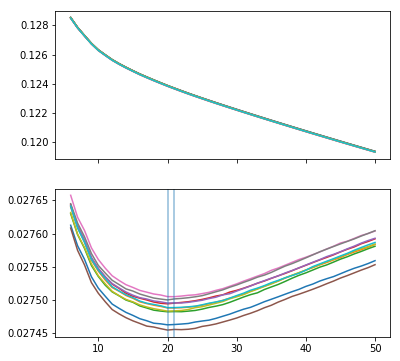

In [5]:
fig,ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

k = 5

ax[0].plot(k_range[k:], rec_loss[:,k:].T)
ax[1].plot(k_range[k:], mcv_loss[:,k:].T)

for v in set(k_range[np.argmin(mcv_loss, axis=1)]):
    ax[1].axvline(v, alpha=0.5)

print(k_range[np.argmin(mcv_loss, axis=1)])
print(k_range[mcv_loss.mean(0).argmin()])

In [6]:
# genes selected from Figure 2B of Paul, Arkin, & Giladi et al.
marker_genes = [
    'Ccl5', 'Prg2', 'Prss34', 'Meis1',
    'Cebpe', 'Csf1r', 'Cebpa', 'Sfpi1', 'Lgals1', 'Irf8',
    'H2-Aa', 'Cd74', 'Pf4', 'Pbx1;Pbx3', 'Serpina3f;Serpina3g', 'Apoe', 'Gata2',
    'Elane', 'Prtn3', 'Mpo',
    'Flt3', 'Ifitm1', 'Lmo4',
    'Gata1', 'Gfi1b', 'Car1', 'Car2', 'Klf1', 'Zfpm1', 'Cpox', 'Beta-s', 'Hbb-b1', 'Hba-a2',
]

mg_ix_d = {g:i for i,g in enumerate(myeloid_ad.var.index)}
mg_ix = [mg_ix_d[g] for g in marker_genes]

Four versions of the data:
 - raw (no smoothing)
 - under-smooth (too many PCs)
 - optimal smoothing as determined by MCV 
 - over-smooth (too few PCs)

In [7]:
raw = np.sqrt(umis)

# calculate SVD up to 50 principal components
U, S, V = randomized_svd(raw, max_components)

denoised_undersmooth = U.dot(np.diag(S).dot(V))
denoised_optimal = U[:, :20].dot(np.diag(S[:20]).dot(V[:20, :]))
denoised_oversmooth = U[:, :3].dot(np.diag(S[:3]).dot(V[:3, :]))

In [8]:
def cluster_data(X, gene_labels, method='average', metric='euclidean'): 
    i1 = sch.leaves_list(
        sch.linkage(X, method=method, metric=metric, optimal_ordering=True)
    )

    i2 = sch.leaves_list(
        sch.linkage(X.T, method=method, metric=metric, optimal_ordering=True)
    )

    new_gene_labels = [gene_labels[i] for i in i2]

    return i1, i2, new_gene_labels

# cluster and re-order the data according to optimally denoised version
i1, i2, new_labels = cluster_data(denoised_optimal[:, mg_ix], marker_genes)

new_ix_d = {g:i for i,g in enumerate(new_labels)}

In [9]:
# subset to genes of interest and re-order rows and columns
raw_subset = raw[:, mg_ix][np.ix_(i1, i2)]
denoised_undersmooth_subset = denoised_undersmooth[:, mg_ix][np.ix_(i1, i2)]
denoised_optimal_subset = denoised_optimal[:, mg_ix][np.ix_(i1, i2)]
denoised_oversmooth_subset = denoised_oversmooth[:, mg_ix][np.ix_(i1, i2)]

In [10]:
denoised_max = np.max(denoised_optimal_subset, axis=0, keepdims=True)

# scale matrix to the [0, denoised_max] per column
def scale_col(X):
    X = X / denoised_max

    X = np.maximum(0, X)
    X = np.minimum(1, X)

    return X


def plot_heatmap(X, labels, cm, ax, cb=None):
    # cleaning up some gene labels
    label_t = {
        'Pbx1;Pbx3': 'Pbx1/3',
        'Serpina3f;Serpina3g': 'Serpina3f/g',
    }

    m = ax.matshow(
        scale_col(X),
        aspect='auto',
        interpolation=None,
        cmap=cm,
        rasterized=True,
    )

    ax.tick_params(
        axis='both',
        bottom=True, 
        labelbottom=True,
        **{(a+b):False for a in ('', 'label') for b in ('top', 'left', 'right')},
    )

    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(
        [label_t.get(lbl, lbl) for lbl in labels], rotation='vertical', va='top'
    )
    
    if cb is not None:
        plt.colorbar(m, cax=cb)


def plot_hexbin(X, gene_A, gene_B, ax, cb=None):
    # clamp values to be non-negative
    X = np.maximum(X, 0)

    i = new_ix_d[gene_A]
    j = new_ix_d[gene_B]

    # version of 'Blues' colormap that is pure white at the bottom
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "BluesW",
        [(1.0, 1.0, 1.0), (0.0314, 0.188, 0.450)]
    )
    
    m = ax.hexbin(
        X[:, i], X[:, j], gridsize=30, bins='log', cmap=cmap, vmin=1, vmax=200
    )

    ax.set_xlabel(gene_A)
    ax.set_ylabel(gene_B)
    
    if cb is not None:
        plt.colorbar(m, cax=cb)


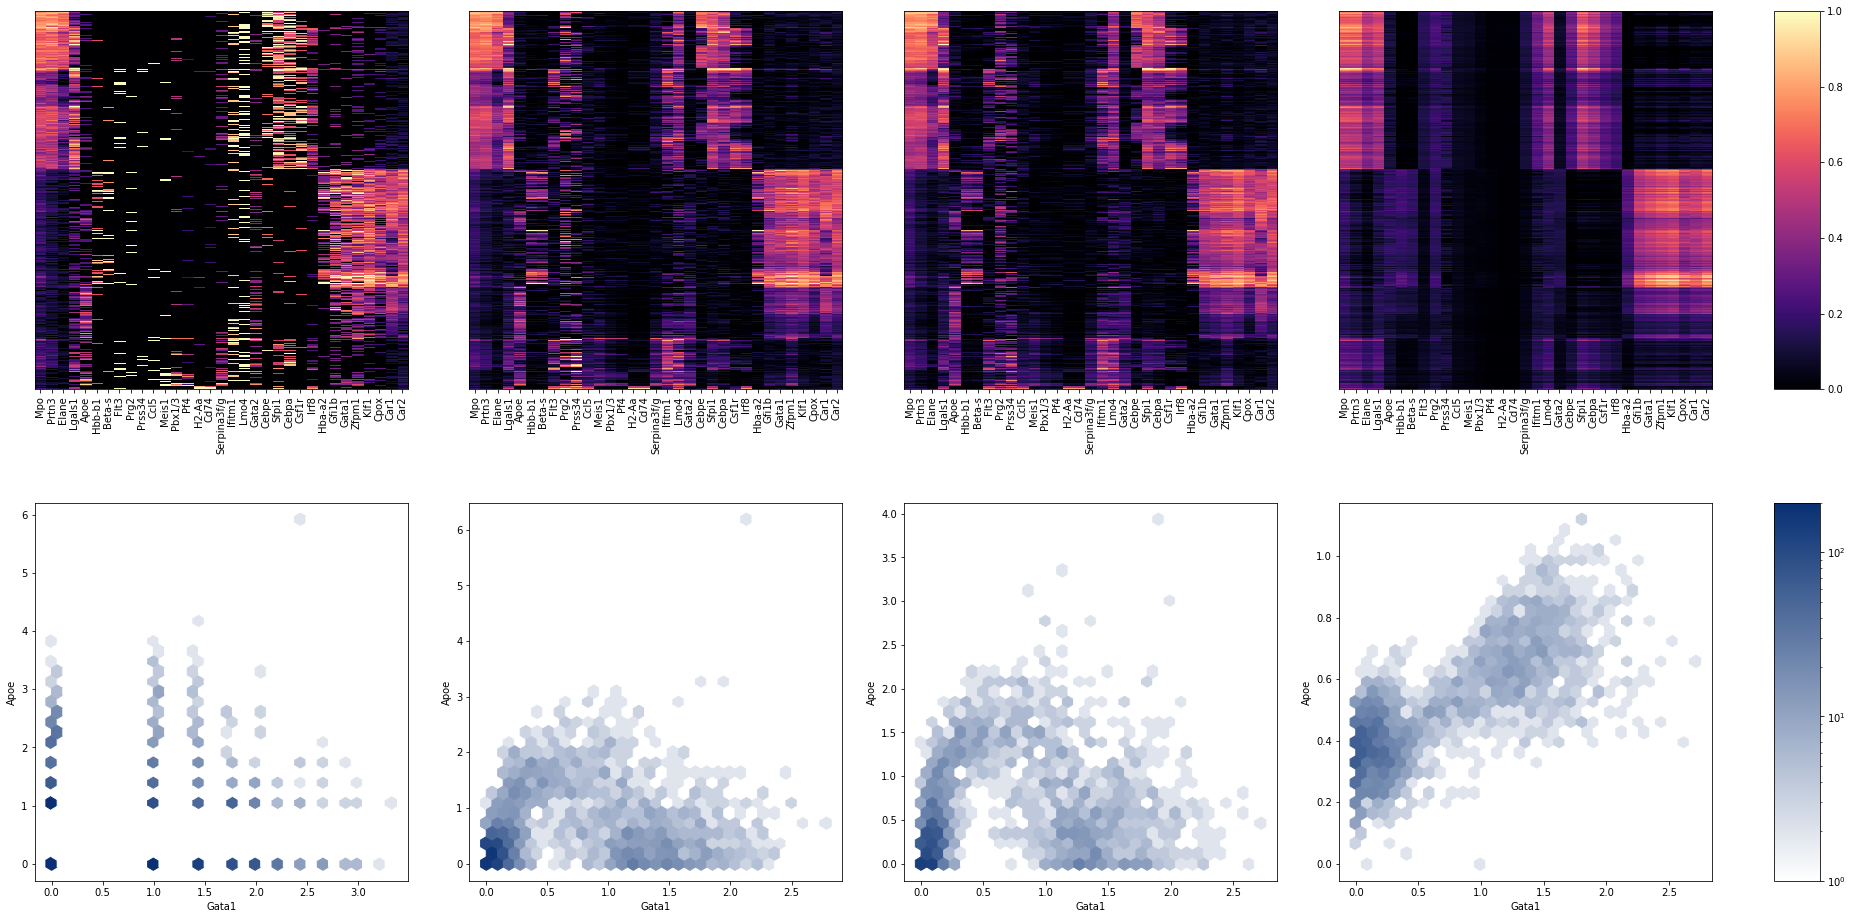

In [11]:
fig,ax = plt.subplots(
    2, 5, figsize=(32, 16),
    gridspec_kw={'hspace': 0.3, 'width_ratios': [8, 8, 8, 8, 1]}
)

for i,X in enumerate(
    (raw_subset, denoised_undersmooth_subset, denoised_optimal_subset, denoised_oversmooth_subset)
):
    plot_heatmap(X, new_labels, matplotlib.cm.magma, ax[0, i], ax[0, i+1] if i == 3 else None)
    
    plot_hexbin(X, "Gata1", "Apoe", ax[1,i], ax[1, i+1] if i == 3 else None)

plt.savefig("../figures/Figure_2_raw.svg")
plt.show()